In [3]:
project_name='Course Project - Art Image Classification'

In [4]:
!pip install opendatasets --upgrade --quiet

In [240]:
import os
import torch
import shutil
import jovian
import pandas as pd
import numpy as np
import opendatasets as od
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from PIL import Image
from copy import copy
from tqdm.notebook import tqdm
%matplotlib inline

In [7]:
od.download('https://www.kaggle.com/ikarus777/best-artworks-of-all-time')

  0%|          | 5.00M/2.29G [00:00<01:17, 31.9MB/s]

100%|██████████| 2.29G/2.29G [00:29<00:00, 84.8MB/s]


## Preparing the Data


In [8]:
artistdata = pd.read_csv('best-artworks-of-all-time/artists.csv')
artistdata.columns

Index(['id', 'name', 'years', 'genre', 'nationality', 'bio', 'wikipedia',
       'paintings'],
      dtype='object')

In [9]:
artistdata[artistdata['paintings']<50]

,id,name,years,genre,nationality,bio,wikipedia,paintings
38,38,Paul Cezanne,1839 – 1906,Post-Impressionism,French,Paul Cézanne (US: or UK: ; French: [pɔl sezan...,https://en.wikipedia.org/wiki/Paul_Cézanne,47
39,39,Eugene Delacroix,1798 – 1863,Romanticism,French,Ferdinand Victor Eugène Delacroix (; French: [...,https://en.wikipedia.org/wiki/Eugène_Delacroix,31
41,41,Georges Seurat,1859 – 1891,Post-Impressionism,French,Georges-Pierre Seurat (French: [ʒɔʁʒ pjɛʁ sœʁa...,https://en.wikipedia.org/wiki/Georges_Seurat,43
48,48,Michelangelo,1475 – 1564,High Renaissance,Italian,Michelangelo di Lodovico Buonarroti Simoni or ...,https://en.wikipedia.org/wiki/Michelangelo,49
49,49,Jackson Pollock,1912 – 1956,Abstract Expressionism,American,"Paul Jackson Pollock (; January 28, 1912 – Aug...",http://en.wikipedia.org/wiki/Jackson_Pollock,24


In [10]:
artists = artistdata.drop(artistdata[artistdata['paintings']<50].index)

In [11]:
artists = artists.sort_values(by=['name'])
artists = artists[['name','genre','nationality','paintings']]
artists['class_weight'] = max(artists.paintings)/artists.paintings
print(len(artists))
artists.head()

45


,name,genre,nationality,paintings,class_weight
19,Albrecht Dürer,Northern Renaissance,German,328,2.673780
20,Alfred Sisley,Impressionism,"French,British",259,3.386100
0,Amedeo Modigliani,Expressionism,Italian,193,4.544041
7,Andrei Rublev,Byzantine Art,Russian,99,8.858586
45,Andy Warhol,Pop Art,American,181,4.845304


In [59]:
weights = artists['class_weight']
class_weights =  torch.FloatTensor(weights).cuda()

In [205]:
imgdir = 'best-artworks-of-all-time/images/images'

In [14]:
os.rename(imgdir+'/Albrecht_Du╠êrer', imgdir+'/Albrecht_Dürer')

In [37]:
shutil.rmtree(imgdir+'/Albrecht_DuΓòá├¬rer')
shutil.rmtree(imgdir+'/Paul_Cezanne')
shutil.rmtree(imgdir+'/Eugene_Delacroix')
shutil.rmtree(imgdir+'/Georges_Seurat')
shutil.rmtree(imgdir+'/Michelangelo')
shutil.rmtree(imgdir+'/Jackson_Pollock')

#### Loading the Data and Applying Transforms

In [536]:
train_tfms = T.Compose([T.Resize((128,128)),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()])

val_tfms = T.Compose([T.Resize((128,128)),
                      T.ToTensor()])

In [537]:
full_dataset = ImageFolder(imgdir)
classes = dataset.classes

In [625]:
train_size = int(0.8*(len(dataset)))
val_size = len(dataset) - train_size
batch_size = 128

train_ds, val_ds = random_split(full_dataset, [train_size, val_size])
train_ds.dataset = copy(full_dataset)

In [626]:
train_ds.dataset.transform = train_tfms
val_ds.dataset.transform = val_tfms

In [627]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [628]:
#calculating mean and stdev for all channels in train_dl
pop_mean = []
pop_std0 = []
pop_std1 = []
for img, label in tqdm(train_dl):
    # shape (batch_size, 3, height, width)
    numpy_image = img.numpy()
    
    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std0 = np.std(numpy_image, axis=(0,2,3))
    batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)
    
    pop_mean.append(batch_mean)
    pop_std0.append(batch_std0)
    pop_std1.append(batch_std1)

# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
pop_mean = np.array(pop_mean).mean(axis=0)
pop_std0 = np.array(pop_std0).mean(axis=0)
pop_std1 = np.array(pop_std1).mean(axis=0)

In [629]:
train_tfms = T.Compose([T.Resize((128,128)),
                        T.RandomHorizontalFlip(),
                        T.ToTensor(),
                        T.Normalize(pop_mean, pop_std0)])

val_tfms = T.Compose([T.Resize((128,128)),
                      T.ToTensor(),
                      T.Normalize(pop_mean, pop_std0)])

train_ds.dataset.transform = train_tfms
val_ds.dataset.transform = val_tfms

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)

In [630]:
random_seed = 42
torch.manual_seed(random_seed);

In [634]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0).clamp(0,1))
        break

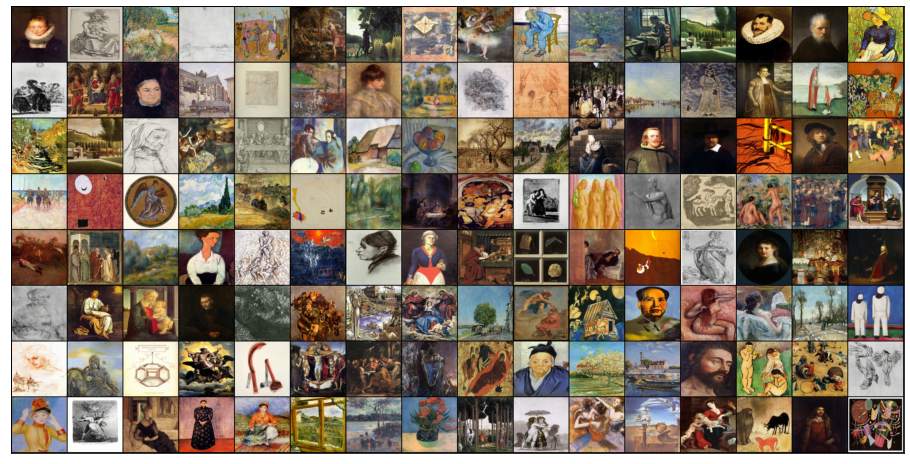

In [635]:
show_batch(train_dl)

In [55]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/yungalejo/course-project-art-image-classification


'https://jovian.ai/yungalejo/course-project-art-image-classification'

### Using GPU

In [454]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [636]:
device = get_default_device()
device

device(type='cuda')

In [637]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

## Model

In [556]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels, weight=class_weights)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels, weight=class_weights)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [557]:
class ArtModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        self.network.fc = nn.Sequential(nn.Linear(self.network.fc.in_features, 512),  
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
                
      

    def forward(self, xb):
        return self.network(xb)

## Training the Model

In [566]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))
  
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [638]:
model = ArtModel(len(classes))
to_device(model, device);

In [639]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.02102581597864628, 'val_loss': 3.83760666847229}]

In [640]:
epochs = 5
lr = 0.0005
weight_decay = 0.0005
opt_func = torch.optim.Adam

In [642]:
%%time
history += fit_one_cycle(epochs, lr, model, train_dl, valid_dl,  
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0],last_lr: 0.00038, train_loss: 3.1940, val_loss: 2.2570, val_acc: 0.3535



Epoch [1],last_lr: 0.00048, train_loss: 1.8397, val_loss: 2.3036, val_acc: 0.4013



Epoch [2],last_lr: 0.00031, train_loss: 1.2190, val_loss: 1.8202, val_acc: 0.5265



Epoch [3],last_lr: 0.00009, train_loss: 0.5716, val_loss: 1.3054, val_acc: 0.6637



Epoch [4],last_lr: 0.00000, train_loss: 0.2696, val_loss: 1.2504, val_acc: 0.6877
CPU times: user 14min 39s, sys: 1min 10s, total: 15min 50s
Wall time: 15min 49s


In [643]:
train_time='15:50'

In [585]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

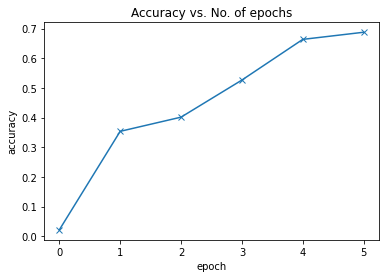

In [644]:
plot_accuracies(history)

In [181]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

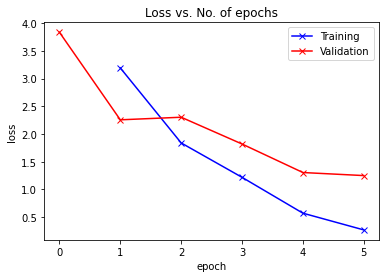

In [645]:
plot_losses(history)

In [589]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

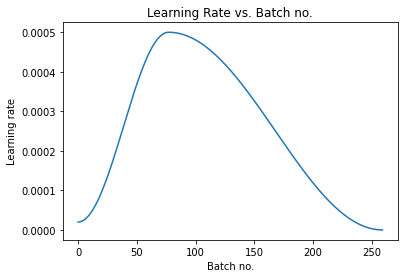

In [646]:
plot_lrs(history)

In [647]:
torch.save(model.state_dict(), 'ArtClassification_Resnet50_Normalized.pth')

In [648]:
jovian.reset()
jovian.log_hyperparams(arch='resnet50', 
                       epochs=epochs, 
                       lr=lr, 
                       scheduler='One Cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=None,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [649]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


## Testing with Individual Images


In [609]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return full_dataset.classes[preds[0].item()]

Label: Alfred_Sisley , Predicted: Alfred_Sisley


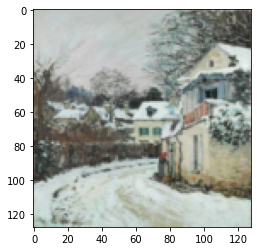

In [650]:
img, label = val_ds[30]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', full_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Francisco_Goya , Predicted: Francisco_Goya


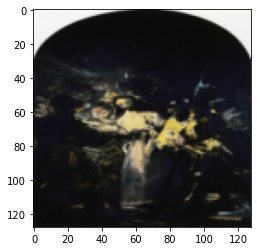

In [651]:
img, label = val_ds[1000]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', full_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Gustav_Klimt , Predicted: Gustav_Klimt


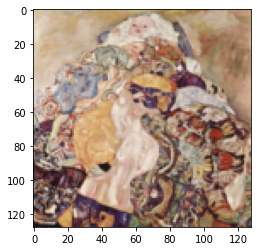

In [652]:
img, label = val_ds[440]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', full_dataset.classes[label], ', Predicted:', predict_image(img, model))

### Test Set

In [653]:
test_loader = DeviceDataLoader(DataLoader(val_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.6877280473709106, 'val_loss': 1.2504316568374634}

## Summary


After much trial and error I was able to get it to classify with 69% accuracy.

By using transfer learning and resnet50 i was able to get a decent result in the end.

I tried many different learning rate schedulers and kept hitting a wall of around 48% regardless of epochs. Even after training for almost 2 hours i did not have much luck.

What i found that helped was to reduce the weight decay parameter to .0005 and to calculate the channel means and stdevs to normalize the data. Also increasing the batch size appears to have a positive effect as well. This allowed me to reduce to a mere 5 epochs and to 16 minutes to acheieve 69%.

Also i applied class weights to the optimizer to account for the varying amount of data for each class.

To improve i believe I may able to include some of the tabular data provided in the csv to create a hybrid of sorts but I am not sure if that would mean that future inputs would always require similar data as provided by the csv file (for example:'country', 'genre')



In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['ArtClassification_Resnet50_Normalized.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...


In [624]:
jovian.submit(assignment="zerotogans-project", project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/yungalejo/course-project-art-image-classification
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/course-project
